In [1]:
from conex.helpers.transforms.encoders import SimplePoisson, Intensity2Latency
from conex.helpers.transforms.misc import Conv2dFilter
from conex.helpers.filters import DoGFilter, GaborFilter

import torch, random, os, sys, time, math
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
from PIL import Image

import plotly.graph_objects as go
import plotly.express as px

In [2]:
def DoG(sigma1, sigma2, size, image):
    if image == "lena":
        image = plt.imread("lena.jpg")
    else:
        image = plt.imread("circle.png")
    image = torch.tensor(image, dtype = torch.float32).mean(2)
    dog = DoGFilter(size = size, sigma_1 = sigma1, sigma_2 = sigma2, dtype = torch.float32, device = "cpu", zero_mean = True, one_sum = True)
    conv = Conv2dFilter(dog.unsqueeze(0).unsqueeze(0), padding = size//2, stride = 1)
    filtered_image = conv(image.unsqueeze(0).unsqueeze(0))
    return dog, filtered_image

def Gabor(size, labda, theta, sigma, gamma, image):
    if image == "lena":
        image = plt.imread("lena.jpg")
    else:
        image = plt.imread("circle.png")
    image = torch.tensor(image, dtype = torch.float32).mean(2)
    gabor = GaborFilter(size = size, labda = labda, theta = theta, sigma = sigma, gamma = gamma, dtype = torch.float32, device = "cpu", zero_mean = True, one_sum = True)
    conv = Conv2dFilter(gabor.unsqueeze(0).unsqueeze(0), padding = size//2, stride = 1)
    filtered_image = conv(image.unsqueeze(0).unsqueeze(0))
    return gabor, filtered_image

def Gaussian_2d(mu_1, mu_2, sigma_1, sigma_2):
    def gaussian(x, y):
        return np.exp(-((x - mu_1)**2 / (2 * sigma_1**2) + (y - mu_2)**2 / (2 * sigma_2**2)))
    
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(x, y)
    z = gaussian(x, y)
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale='Viridis')])
    fig.update_layout(
        title='2D Gaussian Function',
        scene=dict(
            xaxis_title='X axis',
            yaxis_title='Y axis',
            zaxis_title='Gaussian Value'
        ),
        autosize=True,
        width=500,
        height=500
    )
    return fig
    
def TTFS(time_window, threshold, sparsity, filtered_image):
    encoder = Intensity2Latency(time_window = time_window, threshold = threshold, sparsity = sparsity)
    ttfs = encoder(filtered_image.squeeze(0).squeeze(0))
    fig = go.Figure(data=[go.Scatter3d(
        x=ttfs.nonzero(as_tuple=True)[2],
        y=ttfs.nonzero(as_tuple=True)[1],
        z=ttfs.nonzero(as_tuple=True)[0],
        mode='markers',
        marker=dict(
            size=2,
            color='black',                
            colorscale='Viridis',   
            opacity=0.8
        )
    )])

    fig.update_layout(scene = dict(
                        xaxis_title='X',
                        yaxis_title='Y',
                        zaxis_title='Time'),
                        width=700,
                        margin=dict(r=20, l=10, b=10, t=10))
    return fig, ttfs.sum(0)

def Poisson(time_window, ratio, filtered_image):
    p = SimplePoisson(time_window = time_window, ratio = ratio)
    poisson = p(filtered_image.squeeze(0).squeeze(0))
    fig = go.Figure(data=[go.Scatter3d(
        x=poisson.nonzero(as_tuple=True)[2],
        y=poisson.nonzero(as_tuple=True)[1],
        z=poisson.nonzero(as_tuple=True)[0],
        mode='markers',
        marker=dict(
            size=2,
            color='black',               
            colorscale='Viridis',   
            opacity=0.8
        )
    )])
    
    fig.update_layout(scene = dict(
                        xaxis_title='X',
                        yaxis_title='Y',
                        zaxis_title='Time'),
                        width=700,
                        margin=dict(r=20, l=10, b=10, t=10))
    return fig, poisson.sum(0)
    

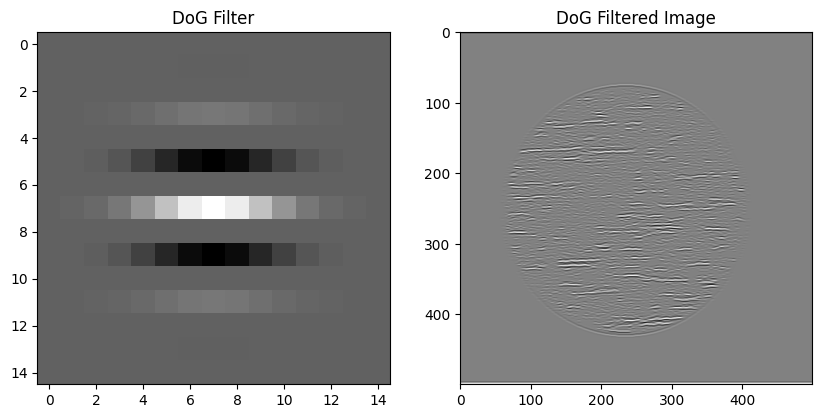

In [5]:
sigma_1 = 1
sigma_2 = 0.5

labda = 4
theta = math.pi
sigma = 2
gamma = 1

time_window = 100
poisson_ratio = 1
threshold = 1
sparsity = 0.1

size = 15
img = "circle"

dog, dog_filtered_image = DoG(sigma_1, sigma_2, size, img)
gabor, gabor_filtered_image = Gabor(size, labda, theta, sigma, gamma, img)

ttfs_fig, ttfs = TTFS(time_window, threshold, sparsity, gabor_filtered_image)
poisson_fig, poisson = Poisson(time_window, poisson_ratio, gabor_filtered_image)

gaussian_fig = Gaussian_2d(0, 0, sigma_1, sigma_2)





# draw dog filter and filtered image
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].imshow(gabor, cmap = "gray")
axs[0].set_title("DoG Filter")
axs[1].imshow(gabor_filtered_image.squeeze(0).squeeze(0), cmap = "gray")
axs[1].set_title("DoG Filtered Image")
plt.show()

# poisson_fig.show()